In [75]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow import keras
import tensorflow_probability as tfp

### Background

#### Policy Gradient

강화학습 기법 중 하나인 Policy Gradient는 현재 상황 state s가 주어졌을때, 특정 action a를 취할 확률을 계산하는 "함수"인 policy를 업데이트하는 방법입니다.

$$ \vdots $$

이때 이 policy를 π로, policy의 파라미터를 θ로 기술합니다. 
예를 들어 πθ(a|s)는 state s가 주어졌을 때 action a를 취할 확률을 뜻합니다. 

policy gradient에선 neural network를 policy로 정의하기에, 파라미터 θ는 곧 신경망 π의 파라미터인 가중치(wight), 편향(bias)로 구성됩니다.
따라서 policy의 정의는 state 학률분포를 입력받아 action 확률분포를 출력하는 신경망으로, 위처럼 πθ(a|s)로 표현할수 있습니다.


policy gradient의 최종 목표는 정책함수 J(θ)는 누적보상이 최대화되는 방향으로 학습을 진행하기에, gradient ascent를 사용하여 θ를 업데이트 하여 πθ를 최적화하는 것을 목표로 합니다.



![policy](assets/pg_2.png?raw=true)

![policy](assets/pg_3.png?raw=true)

<!-- ![policy](assets/pg_1.png) -->

$$\theta^{'} \leftarrow \theta + \alpha \nabla_{\theta} J(\theta)$$

$$\nabla_{\theta} J(\theta) = \frac{\partial J(\theta)}{\partial \theta}$$

$$J(\theta) = \mathbb{E}_{\pi_\theta} \left[ r \right]$$
$$ = \sum_{s\in S} d(s) \sum_{a \in A} \pi(s,a)R_{(s,a)} $$

$$ \nabla_{\theta}J{\theta} = \sum_{s\in S} d(s) \sum_{a \in A} \pi(s,a) \nabla_{\theta} \log \pi_{\theta}(s,a) R_{(s,a)} $$

$$ = \mathbb{E}[\nabla_{\theta}\log \pi_{\theta}(s,a) r] $$


#### 강화학습 환경 설명

- 사용 라이브러리 및 게임 : gym, Cartpole-v1

- 게임 설명 : 2차원 평면 상에 막대를 지지하는 카트를 좌우 이동시키며 컨트롤 한다. 이때 위에 들고 있는 막대가 기울어진 각도에 따라 땅으로 기울게 되는데, 

일정 각도 이하로 기울어지면 패배하므로 카트를 움직여 막대의 지지점을 이동시켜 최대한 오랫동안 지지하여 승리하는 게임이다.

![policy](assets/cartpole.png?raw=true)



> 주요 파라미터
- State
- Action
- Rewards

#### Cartpole 게임 주요 코드


1. 환경세팅
 - env = gym.make("CartPole-v1")  -> # 게임환경 env 생성
 - env = gym.make("CartPole-v1", render_mode='human')  -> # 게임환경 env 생성. 창을 띄워 게임현향을 rendering합니다.

2. 환경초기화
 - state = env.reset()[0]  -> # 게임을 초기화하여 특정 초기 상태로 되돌린다. 이때 state가 리턴되어 다음 행동 결정에 사용됩니다.

3. 게임 1step 진행
 - new_state, reward, term, trunc, _ = env.step(action)  -> # 결정한 action(0 혹은 1의 int값)을 입력하여 카트의 움직임을 결정합니다. 카트가 움직여 게임이 진행되면 새로운 state와 그에 따른 보상(0. 혹은 1.의 float 값)을 리턴받습니다.

### 구현 Code

#### Dense레이어 및 전체 신경망 모듈 생성

In [76]:
class Dense(tf.Module):
    def __init__(self, in_features, out_features, activations=True):
        super().__init__()
        # self.weight = tf.Variable(tf.random.uniform(shape=[in_features, out_features], minval=-0.5, maxval=0.5))
        self.weight = tf.Variable(tf.random.normal(shape=[in_features, out_features], 
                                                   mean=0.0, stddev=0.25, dtype=tf.float32))
        self.bias = tf.Variable(tf.zeros([out_features], dtype=tf.float32))
        self.activations = activations

    def __call__(self, x):
        y = tf.matmul(x, self.weight) + self.bias
        if self.activations:
            return tf.nn.relu(y)
        return tf.nn.softmax(y)

class SequentialModule(tf.Module):
    def __init__(self, input_size, hidden_size, output_size, name="SequentialModule"):
        super().__init__(name=name)
        self.dense_1 = Dense(in_features=input_size, out_features=hidden_size)
        self.dense_2 = Dense(in_features=hidden_size, out_features=hidden_size)
        self.dense_3 = Dense(in_features=hidden_size, out_features=output_size, activations=False)

    def __call__(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        logits = self.dense_3(x)
        return logits

In [77]:
class Agent:
    def __init__(self, alpha=0.01, gamma=0.99, n_actions=2, n_obs=4,
                 neurons1=256, neurons2=256):
        self.gamma = gamma
        self.alpha = alpha
        self.n_actions = n_actions
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

        self.score_history = []
        self.avg_history = []

        # 모델 및 Adam 옵티마이저 설정.
        self.policy = SequentialModule(n_obs, neurons1, n_actions)
        self.opt = tf.optimizers.Adam(learning_rate=alpha)
        
    def choose_action(self, observation):
        # 주어진 state에 대해서 actions 확률을 추론하고, 
        # 이 actions에 대해서 Log 확률분포를 취한 뒤에 "확률분포에 따른" 랜덤샘플링을 진행한다.
        # 이는 현재 상태에서 right 방향으로 이동하는 확률이 매우 높다면, actions 확률 분포의 랜덤 샘플링 결과에서 right가 나올 확률이 높아지는 것을 의미한다.
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        probs = self.policy(state)
        distribuition_actions = tfp.distributions.Categorical(probs=probs)
        action_choosed = distribuition_actions.sample()
        return action_choosed.numpy()[0]

    def store_transition(self, observation, action, reward):
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
    
    def learn(self):
        actions = tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        reward = tf.convert_to_tensor(self.reward_memory, dtype=tf.float32)
        
        cum_rewards = np.zeros_like(reward)
        reward_len = len(reward)
        for j in reversed(range(reward_len)):
            cum_rewards[j] = reward[j] + (cum_rewards[j+1]*self.gamma if j+1 < reward_len else 0)

        # with tape에서 연산되는 과정을 미분하며 backward할수 있는 기능이다.
        # 앞서 정의했던대로, 최종적으로 구하려는 score function의 gradient는
        # 1. log(현재 state를 입력으로 받아 출력된 신경망의 action 확률분포)
        # 2. 해당 action 확률 분포에 따른 행동을 취했을때의 reward
        # 이 두 요소를 곱해주고, 이에 대한 기댓값이 최종적으로 구하려는 dJ (score function의 gradient)다.

        # with tf.GradientTape() as tape:
            # loss = 0
            # for idx, (g, state) in enumerate(zip(cum_rewards, self.state_memory)):
            #     state = tf.convert_to_tensor([state], dtype=tf.float32)
            #     probs = self.policy(state)
            #     action_probs = tfp.distributions.Categorical(probs=probs)
            #     log_prob = action_probs.log_prob(actions[idx])
            #     loss += - g * tf.squeeze(log_prob)

        with tf.GradientTape() as tape:
            
            state = tf.convert_to_tensor(self.state_memory, dtype=tf.float32)
            probs = self.policy(state)
            action_probs = tfp.distributions.Categorical(probs=probs)
            log_prob = action_probs.log_prob(actions)
            loss = - cum_rewards * tf.squeeze(log_prob)
            
            gradient = tape.gradient(loss, self.policy.trainable_variables)

            # 각 gradient값들을 이용하여 최적화 진행.
            self.opt.apply_gradients(zip(gradient, self.policy.trainable_variables))

        # 스코어 합을 저장하고, 최근 20 에피소드간의 스코어 합 평균을 리스트에 저장하여 학습의 진전을 확인하는 용도
        self.score_history.append(sum(self.reward_memory))
        self.avg_history.append(np.mean(self.score_history[-20:]))

        # 한 에피소드가 끝나면 기존의 state, action, reward 리스트를 비워버린다.
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
    
    def early_stopping(self, last_count):
        last_score = np.array(self.avg_history[-last_count:])
        if np.count_nonzero(last_score[last_score > 500.0]) == last_count:
            print("Early Stopping....")
            return True
        return False

    
    def load_model(self, path):
        checkpoint = tf.train.Checkpoint(self.policy)
        checkpoint.restore(f'{path}-1')

    def save_model(self, path):
        checkpoint = tf.train.Checkpoint(self.policy)
        save_path = checkpoint.save(path)
        print(save_path)
        
        



In [78]:
# env = gym.make("CartPole-v1", render_mode='human')
env = gym.make("CartPole-v1", )
agent = Agent(alpha=0.0005, gamma=0.99, n_actions=env.action_space.n, n_obs=env.observation_space.shape[0])
episodes = 250

In [79]:
# # If you want to see trained model:
# path = os.path.join("Saved Models", "My_trained_Models")
# agent.load_model(path)

# # If you want to save your custom model:
# path = os.path.join("Saved Models", "My_trained_Models")
# agent.save(path)

# # Testing with trained model:
# score_history = []
# avg_history = []
# for i in range(episodes):
#     done = False
#     score = 0
#     observation = env.reset()[0]
#     while not done:
#         action = agent.choose_action(observation)
#         observation_, rew, done, _, _ = env.step(action)
#         agent.store_transition(observation, action, rew)
#         observation = observation_
#         score += rew
#     score_history.append(score)
#     avg_history.append(np.mean(score_history[-20:]))
#     print(f'Episode: {i} // Score: {avg_history[-1]}')

In [80]:
for i in range(episodes):
    done = False
    score = 0
    state = env.reset()[0]
    while not done:
        action = agent.choose_action(state)
        new_state, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        agent.store_transition(state, action, reward)
        state = new_state
        score += reward

    agent.learn()
    print(f'Episode: {i} // Score: {agent.avg_history[-1]}', end="\r")
    if agent.early_stopping(5):
        break



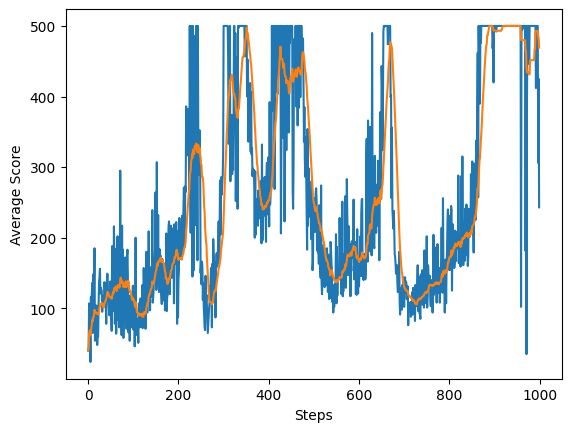

In [85]:
plt.plot(list(range(len(agent.score_history))), agent.score_history)
plt.plot(list(range(len(agent.avg_history))), agent.avg_history)
plt.xlabel('Steps')
plt.ylabel('Average Score')
plt.show()

In [82]:
# agent.save_model('./checkpoints/best_model')